In [1]:
%matplotlib inline


# Gridding with Scipy

Scipy offers a range of interpolation methods in :mod:`scipy.interpolate` and 3
specifically for 2D data (linear, nearest neighbors, and bicubic). Verde offers
an interface for these 3 scipy interpolators in :class:`verde.ScipyGridder`.

All of these interpolations work on Cartesian data, so if we want to grid
geographic data (like our Baja California bathymetry) we need to project them
into a Cartesian system. We'll use `pyproj
<https://github.com/jswhit/pyproj>`__ to calculate a Mercator projection for
the data.

For convenience, Verde still allows us to make geographic grids by passing the
``projection`` argument to :meth:`verde.ScipyGridder.grid` and the like. When
doing so, the grid will be generated using geographic coordinates which will be
projected prior to interpolation.


Gridder used: ScipyGridder()
Data region: (245.0, 254.705, 20.0, 29.99131)
Generated geographic grid:
<xarray.Dataset>
Dimensions:       (latitude: 121, longitude: 117)
Coordinates:
  * longitude     (longitude) float64 245.0 245.1 245.2 ... 254.5 254.6 254.7
  * latitude      (latitude) float64 20.0 20.08 20.17 ... 29.82 29.91 29.99
Data variables:
    bathymetry_m  (latitude, longitude) float64 nan nan nan nan ... nan nan nan
Attributes:
    metadata:  Generated by ScipyGridder()


/home/m/anaconda3/envs/fatiando-tutorials/lib/python3.9/site-packages/verde/base/base_classes.py:463: FutureWarning: The 'spacing', 'shape' and 'region' arguments will be removed in Verde v2.0.0. Please use the 'verde.grid_coordinates' function to define grid coordinates and pass them as the 'coordinates' argument.
  warnings.warn(


/home/m/anaconda3/envs/fatiando-tutorials/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/m/anaconda3/envs/fatiando-tutorials/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/m/anaconda3/envs/fatiando-tutorials/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


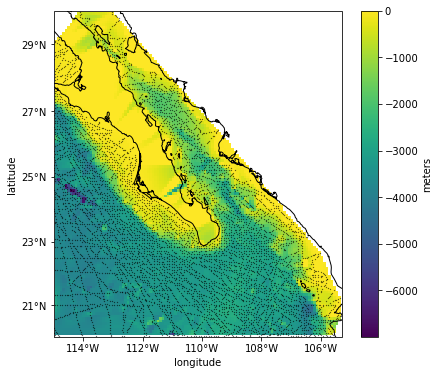

In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pyproj

import verde as vd

# We'll test this on the Baja California shipborne bathymetry data
data = vd.datasets.fetch_baja_bathymetry()

# Before gridding, we need to decimate the data to avoid aliasing because of
# the oversampling along the ship tracks. We'll use a blocked median with 5
# arc-minute blocks.
spacing = 5 / 60
reducer = vd.BlockReduce(reduction=np.median, spacing=spacing)
coordinates, bathymetry = reducer.filter(
    (data.longitude, data.latitude), data.bathymetry_m
)

# Project the data using pyproj so that we can use it as input for the gridder.
# We'll set the latitude of true scale to the mean latitude of the data.
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
proj_coordinates = projection(*coordinates)

# Now we can set up a gridder for the decimated data
grd = vd.ScipyGridder(method="cubic").fit(proj_coordinates, bathymetry)
print("Gridder used:", grd)

# Get the grid region in geographic coordinates
region = vd.get_region((data.longitude, data.latitude))
print("Data region:", region)

# The 'grid' method can still make a geographic grid if we pass in a projection
# function that converts lon, lat into the easting, northing coordinates that
# we used in 'fit'. This can be any function that takes lon, lat and returns x,
# y. In our case, it'll be the 'projection' variable that we created above.
# We'll also set the names of the grid dimensions and the name the data
# variable in our grid (the default would be 'scalars', which isn't very
# informative).
grid = grd.grid(
    region=region,
    spacing=spacing,
    projection=projection,
    dims=["latitude", "longitude"],
    data_names="bathymetry_m",
)
print("Generated geographic grid:")
print(grid)

# Cartopy requires setting the coordinate reference system (CRS) of the
# original data through the transform argument. Their docs say to use
# PlateCarree to represent geographic data.
crs = ccrs.PlateCarree()

plt.figure(figsize=(7, 6))
# Make a Mercator map of our gridded bathymetry
ax = plt.axes(projection=ccrs.Mercator())
ax.set_title("Gridded Bathymetry Using Scipy")
# Plot the gridded bathymetry
pc = grid.bathymetry_m.plot.pcolormesh(
    ax=ax, transform=crs, vmax=0, zorder=-1, add_colorbar=False
)
plt.colorbar(pc).set_label("meters")
# Plot the locations of the decimated data
ax.plot(*coordinates, ".k", markersize=0.5, transform=crs)
# Use an utility function to setup the tick labels and the land feature
vd.datasets.setup_baja_bathymetry_map(ax)
plt.show()